In [140]:
import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import uuid

In [141]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Conv2D, Layer, MaxPooling2D, Input, Dense
import tensorflow as tf

## For GPU Computers

In [142]:
# gpus = tf.config.list_physical_devices("GPU")
# for gpu in gpus:
#     tf.experimental.set_memory_growth(gpu,True)

## Make Directories

In [10]:
Positive_path = os.path.join("Data","positive")
Negative_path = os.path.join("Data","negative")
Anchors_path = os.path.join("Data","anchors")

In [5]:
try:
    os.mkdir("Data")
except:
    print("Directory already created")

try:
    os.mkdir(Positive_path)
except:
    print("Directory already created")

try:
    os.mkdir(Negative_path)
except:
    print("Directory already created")
    
try:
    os.mkdir(Anchors_path)
except:
    print("Directory already created")

Directory already created
Directory already created
Directory already created
Directory already created


# Input Datas Positive and Negative

# Negative Files
### http://vis-www.cs.umass.edu/lfw/

In [6]:
# !tar -xf lfw.tgz

# for direc in os.listdir("lfw"):
#     for file in os.listdir(f"lfw\{direc}"):
#         old_path = os.path.join("lfw",direc,file)
#         new_path = os.path.join(Negative_path,file)
#         os.replace(old_path,new_path)

# Positive Files

In [7]:
cap = cv2.VideoCapture(0) # Establish connection to webcam
print("CV_CAP_PROP_FRAME_WIDTH: '{}'".format(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
print("CV_CAP_PROP_FRAME_HEIGHT : '{}'".format(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

starting_height = 150
starting_width = 180

while cap.isOpened():
    ret, frame = cap.read() # return value and frame
    
    frame = frame[starting_height:starting_height+250,starting_width:starting_width+250,:]
    
    # Save positives and anchors
    if cv2.waitKey(1) & 0XFF == ord("p"):
        positive_image = os.path.join(Positive_path,"{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(positive_image,frame)
        
    if cv2.waitKey(1) & 0XFF == ord("a"):
        anchor_image = os.path.join(Anchors_path,"{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(anchor_image,frame)
    
    
    cv2.imshow("Image_Collection_Positive", frame) #Show Image
    
    if cv2.waitKey(1) & 0XFF == ord("q"):
        break
# Release webcam
cap.release()
# Close image show frame
cv2.destroyAllWindows()

CV_CAP_PROP_FRAME_WIDTH: '640.0'
CV_CAP_PROP_FRAME_HEIGHT : '480.0'


In [8]:
# capture=cv2.VideoCapture(0)
  
# # showing values of the properties
# print("CV_CAP_PROP_FRAME_WIDTH: '{}'".format(capture.get(cv2.CAP_PROP_FRAME_WIDTH)))
# print("CV_CAP_PROP_FRAME_HEIGHT : '{}'".format(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
# print("CAP_PROP_FPS : '{}'".format(capture.get(cv2.CAP_PROP_FPS)))
# print("CAP_PROP_POS_MSEC : '{}'".format(capture.get(cv2.CAP_PROP_POS_MSEC)))
# print("CAP_PROP_FRAME_COUNT  : '{}'".format(capture.get(cv2.CAP_PROP_FRAME_COUNT)))
# print("CAP_PROP_BRIGHTNESS : '{}'".format(capture.get(cv2.CAP_PROP_BRIGHTNESS)))
# print("CAP_PROP_CONTRAST : '{}'".format(capture.get(cv2.CAP_PROP_CONTRAST)))
# print("CAP_PROP_SATURATION : '{}'".format(capture.get(cv2.CAP_PROP_SATURATION)))
# print("CAP_PROP_HUE : '{}'".format(capture.get(cv2.CAP_PROP_HUE)))
# print("CAP_PROP_GAIN  : '{}'".format(capture.get(cv2.CAP_PROP_GAIN)))
# print("CAP_PROP_CONVERT_RGB : '{}'".format(capture.get(cv2.CAP_PROP_CONVERT_RGB)))
  
# # release window
# capture.release()
# cv2.destroyAllWindows()

# Preprocessing

In [11]:
positive = tf.data.Dataset.list_files(os.path.join(Positive_path,"*.jpg")).take(300)
negative = tf.data.Dataset.list_files(os.path.join(Negative_path,"*.jpg")).take(300)
anchor = tf.data.Dataset.list_files(os.path.join(Anchors_path,"*.jpg")).take(300)

In [12]:
def prepro(data_path):
    bitting_img = tf.io.read_file(data_path)
    img = tf.io.decode_jpeg(bitting_img)
    img = tf.image.resize(img, (100,100))
    img = img/255.0
    return img

In [13]:
anchor

<_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [14]:
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

data = positives.concatenate(negatives)

In [15]:
def preprocess_twin(anchor,data,label):
    return(prepro(anchor),prepro(data),label)

In [16]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [17]:
# training partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# testing partition
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Making Layers

In [18]:
def make_embedding():
    # c1,c2,c3,c4 is convolution+relu+stride layer
    # m1,m2,m3 is max pooling layer
    
    input_layer = Input(shape=(100,100,3),name="Input_Image")
    
    # First Block
    c1 = Conv2D(64,(10,10), activation="relu")(input_layer)
    m1 = MaxPooling2D(64,(2,2), padding="same")(c1)
    
    # Second Block
    c2 = Conv2D(128,(7,7), activation="relu")(m1)
    m2 = MaxPooling2D(128,(2,2), padding="same")(m1)
    
    # Third Block
    c3 = Conv2D(128,(4,4), activation="relu")(m2)
    m3 = MaxPooling2D(64,(2,2), padding="same")(c3)
    
    # Final Block
    c4 = Conv2D(256, (4,4), activation = "relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)
    
    return Model(inputs=[input_layer] ,outputs=[d1] ,name="embedding" )

In [19]:
embedding_model = make_embedding()

In [20]:
embedding_model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0 

In [21]:
# l1Dist
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    
    # Compare similarity
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [22]:
def make_siamese_model():
    
    input_image = Input(name="Input_image", shape=(100,100,3))
    
    validation_image = Input(name="Anchor_image", shape=(100,100,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding_model(input_image), embedding_model(validation_image))
    
    classifier = Dense(1, activation="sigmoid")(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork")

In [23]:
siamese_model = make_siamese_model()

In [24]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_image (InputLayer)    [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 Anchor_image (InputLayer)   [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 embedding (Functional)      (None, 4096)                 5205932   ['Input_image[0][0]',         
                                                          8          'Anchor_image[0][0]']        
                                                                                                  
 distance (L1Dist)           (None, 4096)                 0         ['embedding[0][0]

# Training

In [25]:
binary_xentropy_loss = tf.losses.BinaryCrossentropy()

In [26]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [27]:
try:
    os.mkdir("training_checkpoint")
except:
    print("Training checkpoint made")

Training checkpoint made


In [28]:
checkpoint_dir = "./training_checkpoint"
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(opt=optimizer,siamese_model=siamese_model)

In [29]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        x = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(x, training=True)
        
        loss = binary_xentropy_loss(y, yhat)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    optimizer.apply_gradients(zip(grad,siamese_model.trainable_variables))
    
    return loss

In [30]:
def train_loop(train_data, Epochs):
    for Epoch in range(1,Epochs+1):
        print("\n Epoch {}/{}".format(Epoch,Epochs))
        progbar = tf.keras.utils.Progbar(len(train_data))
        
        for idx, batch in enumerate(train_data):
            train_step(batch)
            progbar.update(idx+1)
            
            if Epoch % 10 ==0:
                checkpoint.save(file_prefix=checkpoint_prefix)

In [31]:
Epochs = 60

In [32]:
# train_loop(train_data,Epochs)

# Metrics

In [62]:
from tensorflow.keras.metrics import Precision, Recall, F1Score

In [132]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next() # Input, validation image, and value

In [133]:
predictions = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 1s/step


In [134]:
asd = np.array([1 if prediction > 0.5 else 0 for prediction in predictions])

In [135]:
asd

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1])

In [136]:
y_true

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [137]:
m = F1Score()
m.update_state(np.expand_dims(y_true,1),np.expand_dims(asd,1))
m.result().numpy() # 0 to 1, value of recall

array([0.30769232], dtype=float32)

In [138]:
m = Recall()
m.update_state(y_true,predictions)
m.result().numpy() # 0 to 1, value of recall

0.6666667

In [131]:
m = Precision()
m.update_state(y_true,predictions)
m.result().numpy() # 0 to 1, value of recall

0.6666667

# Calculate Average Precision, Recall, F1 Score

In [73]:
from tqdm import tqdm

In [92]:
avg_precision = 0
avg_recall = 0
avg_f1score = 0


for i in range(100):


    test_input, test_val, y_true = test_data.as_numpy_iterator().next() # Input, validation image, and value
    predictions = siamese_model.predict([test_input, test_val])
    [1 if prediction > 0.5 else 0 for prediction in predictions]
    m = F1Score()
    m.update_state(np.expand_dims(y_true,1),predictions)
    temp_f1score = float(m.result().numpy()) # 0 to 1, value of recall
    avg_f1score = avg_f1score+temp_f1score
    
    m = Recall()
    m.update_state(y_true,predictions)
    m.result().numpy() # 0 to 1, value of recall
    temp_recall = float(m.result().numpy()) # 0 to 1, value of recall
    avg_recall = avg_recall+temp_recall
    
    m = Precision()
    m.update_state(y_true,predictions)
    m.result().numpy() # 0 to 1, value of recall
    temp_precision = float(m.result().numpy()) # 0 to 1, value of recall
    avg_precision = avg_precision+temp_precision

1/1 [==============================] - 1s 1s/step


In [139]:
print("="*100)
print(f"Precision : {avg_precision/100}")
print(f"Recall : {avg_recall/100}")
print(f"F1-Score : {avg_f1score/100}")
print("="*100)

Precision : 0.440013133212924
Recall : 0.4853643663972616
F1-Score : 0.6400523623824119


# Image Test

In [88]:
val_test = 5

0.0


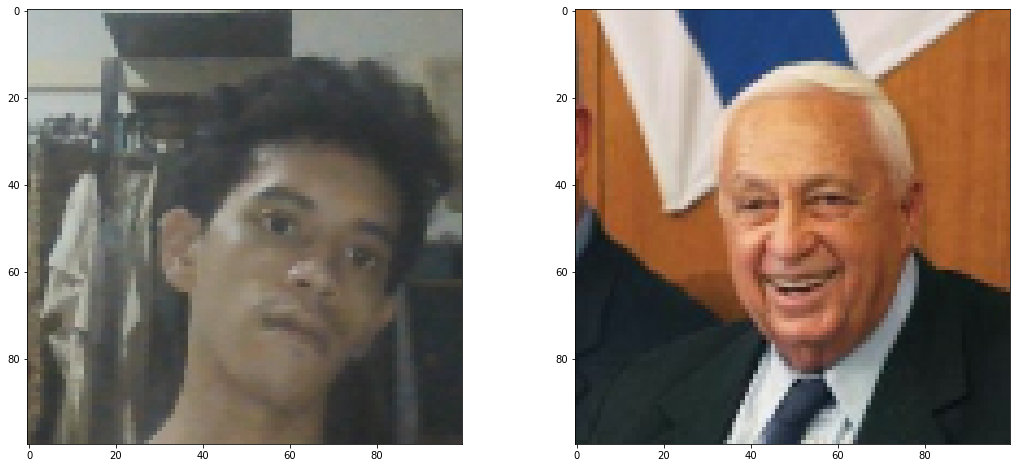

In [89]:
print(y_true[val_test])

plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[val_test])
plt.subplot(1,2,2)
plt.imshow(test_val[val_test])
plt.show()

# Save Model

In [41]:
# siamese_model.save("siamese_model.h5")

In [42]:
model = tf.keras.models.load_model("siamese_model.h5",custom_objects={"L1Dist":L1Dist, 
                                                                           "binary_xentropy_loss":tf.losses.BinaryCrossentropy})

In [44]:
test_input.shape

(16, 100, 100, 3)

In [51]:
y_true

array([1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

In [45]:
y_pred = model.predict([test_input,test_val])

1/1 [==============================] - 1s 1s/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [5.4005547e-09],
       [1.0462755e-11],
       [4.1564053e-06],
       [3.6553405e-07],
       [4.6228008e-10],
       [9.9999434e-01],
       [1.0000000e+00],
       [8.3171345e-09],
       [4.7177556e-10],
       [9.9999857e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9989796e-01]], dtype=float32)

In [42]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_image (InputLayer)    [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 Anchor_image (InputLayer)   [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 embedding (Functional)      (None, 4096)                 5205932   ['Input_image[0][0]',         
                                                          8          'Anchor_image[0][0]']        
                                                                                                  
 l1_dist_1 (L1Dist)          (None, 4096)                 0         ['embedding[0][0]

# Real-Time

In [43]:
try:
    os.mkdir("application_data")
except:
    print("Dir created")
    
try:
    os.mkdir("application_data/verification_images")
except:
    print("Dir created")
    
try:
    os.mkdir("application_data/input_images")
except:
    print("Dir created")

Dir created
Dir created
Dir created


In [143]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    
    for image in os.listdir("application_data/verification_images"):
        input_img = prepro("application_data/input_images/input_image.jpg")
        verif_img = prepro(f"application_data/verification_images/{image}")
        
        result = model.predict(list(np.expand_dims([input_img,verif_img],axis=1)))
        results.append(result)
        
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection/len(os.listdir("application_data/verification_images"))
    verified = verification>verification_threshold
    
    return results, verified, detection, verification

In [144]:
# results = []

# for image in os.listdir("application_data/verification_images"):
#     input_img = prepro("application_data/input_images/input_image.jpg")
#     verif_img = prepro(f"application_data/verification_images/{image}")

#     result = model.predict(list(np.expand_dims([input_img,verif_img],axis=1)))
#     results.append(result)

In [146]:
cap = cv2.VideoCapture(0)
starting_height = 150
starting_width = 180

while cap.isOpened():
    res, frame = cap.read()
    
    frame = frame[starting_height:starting_height+250,starting_width:starting_width+250,:]
    
    cv2.imshow("Verification", frame)
    
    #Verification trigger
    if cv2.waitKey(10) & 0XFF == ord("v"):
        cv2.imwrite("application_data/input_images/input_image.jpg",frame)
        
        results, verified, detection, verification = verify(model,  0.3, 0.3)
        print(detection, verification)
        print(verified)
    
    if cv2.waitKey(10) & 0XFF == ord("q"):
        break
        
cap.release()
cv2.destroyAllWindows()

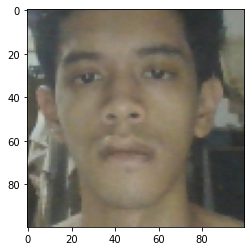

In [85]:
plt.imshow(input_img)